**Step 1 : 首先针对获取到的数据进行第一步筛选：时间筛选，筛选出存在时间大于2000秒的数据.因为Instagram只能爬取到最近发布的动态，所以我们尽可能的筛选出发布时间最久的动态**

In [3]:
import os

def sort_by_time():
    image_url = ["/home/wxr/hyx/SELFIE/SpiderForSelfie-0.1.1/data",]
    image_sort = "/home/wxr/hyx/SELFIE/SpiderForSelfie-0.1.1/data_sort_longer_than_1000"

    for path_name in image_url:
        for name in sorted(os.listdir(path_name)):
            path = os.path.join(path_name,name)
            f = open(path,"rU")
            path_write = os.path.join(image_sort,name)
            f_write = open(path_write,"w")
            line = f.readline()
            while line:
                if len(line.split("	")) > 3:
                    try :
                        if (int)(line.split("	")[3]) > 2000:
                            f_write.write(line)
                    except:
                        pass
                line = f.readline() 
            f.close()
sort_by_time()

**Step 2 : 对上一步筛选的数据进行分析，获取点赞数和粉丝数并绘图，如图可见，点赞数和粉丝数都非常集中**

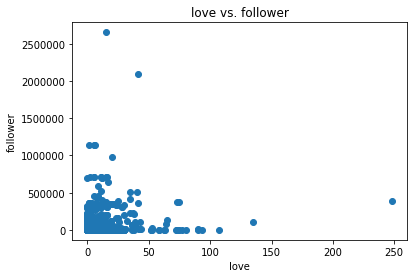

In [3]:
import pylab as pl

pl.title('love vs. follower')# give plot a title
pl.xlabel('love')# make axis labels
pl.ylabel('follower')
pl.plot(x, y, 'o')# use pylab to plot x and y
pl.show()# show the plot on the screen

**Step 3 : 首先将点赞数和该点赞数的个数进行绘制，查看点赞数的分布情况:可见大多分布在0-10（甚至0-8）之间 因此直接将用户点赞数当作评分，构造一个0-9的10分类问题**

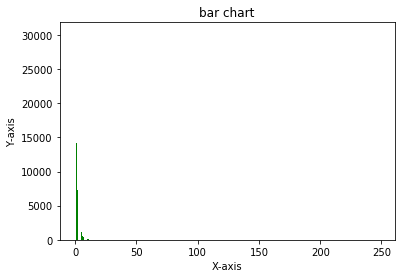

In [4]:
import matplotlib.pyplot as plt 

myset = set(x)
x_axis = []
y_axis = []
for item in myset: 
    y_axis.append(x.count(item))
    x_axis.append(item)
    
fig = plt.figure()  
plt.bar(x_axis,y_axis,0.4,color="green")  
plt.xlabel("X-axis")  
plt.ylabel("Y-axis")  
plt.title("bar chart")  
    
plt.show() 

**Step 4 : 然后查看上一步筛选出来的数据，将重要数据：点赞数、粉丝数进行统计。根据之前统计的经验，我们决定直接将点赞数作为评分，并将该数据写入data_new_grade_direct**

In [2]:
image_url = ["/home/wxr/hyx/SELFIE/SpiderForSelfie-0.1.1/data_sort_longer_than_1000",]
data_new_grade = "/home/wxr/hyx/SELFIE/SpiderForSelfie-0.1.1/data_new_grade_direct.txt"
data_new_grade_write = open(data_new_grade,"w")

pic_set = set()
x = []
y = []
lines = []
line_count = 0 
for path_name in image_url:
    for name in sorted(os.listdir(path_name)):
        if name.endswith(".txt"):
            path = os.path.join(path_name,name)
            f = open(path,"rU")
            line = f.readline()
            while line:
                if (line.split("	")) > 3:
                    if line.split("	")[0] not in pic_set:
                        line_count += 1
                        x.append(int(line.split("	")[1]))
                        y.append(int(line.split("	")[4]))
                        lines.append(line)
                        data_new_grade_write.write(str(line.split("	")[1])+' '+line)
                line = f.readline()
            f.close()
data_new_grade_write.close()
print line_count

60410


**Step 5 : 下载图片，访问刚才筛选出来的图片URL，data_new_grade_direct.txt,将下载好的图片reshape成224，224大小**

In [5]:
#from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from IPython.display import display
import requests
import Image
from io import BytesIO
import h5py
from threading import Thread, Lock

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [ ]:
file_num = [0,0,0]
url_list = []
url_file = open('SpiderForSelfie-0.1.1/data_new_grade_direct.txt', "rU")
for url in url_file:
    if url!='' and url!='\n':
        url_list.append(url)
target_num = len(url_list)

def get_img(urls):
    total_num = len(urls)
    for i in xrange(total_num):
        image_data = urls[i].split("	")[0]
        grade = image_data.split()[0]
        url = image_data.split()[1].replace(' ','')
        love = int(urls[i].split("	")[1])
        fan = int(urls[i].split("	")[4])
        try:
            response = requests.get(url)
            image = Image.open(BytesIO(response.content))
            image_resize = image.resize((224,224),Image.ANTIALIAS)
            image_resize.save('data/image/hyx/img%d_%d.jpg'%(love,fan),'jpeg')
            if (i+1)%30 == 0 or i+1 == total_num:
                sys.stdout.write("\rtotal:%d/%d" % (i,total_num))
                sys.stdout.flush()
        except IOError:
            pass
get_img(url_list)

total:89/60410

**Step 6 : 将下载好的图片和评分一起存储为h5格式**

In [ ]:
import numpy as np
import os
import sys
import Image
import h5py

In [ ]:
def getFileList(path):
    filelist = []
    files = os.listdir(path)
    for f in files:
        if f[0] == '.':
            pass
        else:
            filelist.append(f)
    return filelist
all_images = sorted(getFileList('data/image/hyx'))
total_num=len(all_images)
images=np.empty((total_num,224,224,3),dtype=np.uint8)
grades=np.empty((total_num,),dtype=np.float16)

num = 1
for i in xrange(len(all_images)):
    image_path = 'data/image/hyx/' + all_images[i]
    image = Image.open(image_path)
    image_resize = image.resize((224,224),Image.ANTIALIAS)
    images[i]=np.array(image_resize.convert('RGB'),dtype=np.uint8)
    grade = int(all_images[i].split('_')[0].split('img')[1])
    print grade
    grades[i] = grade
    sys.stdout.write("\rdeal: %d/%d" % (num,total_num))
    sys.stdout.flush()
    del image
    num += 1
s_index = len(all_images)

try:
    with h5py.File('data/portrait_hyx.h5','w') as f:
        f.create_dataset('images', data=images)
        f.create_dataset('labels', data=grades)
except Exception as e:
    print('Unable to save images:', e)

**Step 7 : 搭建神经网络，采用图像处理先进网络VGG16进行特征提取，并在顶层添加了5个全连接层，最后是一个10分类的softMax输出，并将训练好的模型存储下来，以便在webselfie工程中调用**

In [ ]:
import numpy as np
import h5py
import os
from keras.models import Model
import keras
from keras.callbacks import EarlyStopping ,ModelCheckpoint
#from keras import losses
from keras.regularizers import l2
from keras.layers import Activation,Dense,Dropout,Flatten,Input
from keras.utils.np_utils import to_categorical

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

img_path = "/home/wxr/hyx/SELFIE/data/portrait_hyx.h5"
image_row = 224
image_col = 224
channels = 3

In [ ]:
def load_image():
    '''
    read in img(shape:224,224,3) RGB already
    '''
    print 'loading images ...'
    img_file=h5py.File(img_path,'r')
    x = img_file['images'][:]
    y = img_file['labels'][:]

    y_real_index = np.where(y<=9)
    x_ = x[y_real_index]
    y_ = y[y_real_index]
    
    x = x_
    y = y_
    y = to_categorical(np.asarray(y))
    print y
   
    indices = np.arange(len(x))
    np.random.shuffle(indices)
    
    data = x[indices]
    grade = y[indices]
    nb_validation_samples = int(0.2 * len(x))
    
    x_train = data[:-1*nb_validation_samples]
    y_train = grade[:-1*nb_validation_samples]
    x_val = data[-1*nb_validation_samples:]
    y_val = grade[-1*nb_validation_samples:]
    
    
    print y_train.shape
    print y_val.shape
    
    print x_train.shape
    print x_val.shape
    return x_train, y_train, x_val, y_val

In [ ]:
x_train, y_train, x_valid, y_valid = load_image()

print 'finished loading images ! '

mage_input=Input(shape=(image_row, image_col, channels))
conve_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3))
for layer in conve_model.layers:
    layer.trainable = False
features=conve_model.output
features=Flatten(name='flatten')(features)
features=Dense(2048,activation='relu',name='fullc1',W_regularizer=l2(0.03))(features)
features=Dropout(0.5)(features)
features=Dense(1024,activation='relu',name='fullc2',W_regularizer=l2(0.03))(features)
features=Dropout(0.5)(features)
features=Dense(512,activation='relu',name='fullc3',W_regularizer=l2(0.03))(features)
features=Dropout(0.5)(features)
features=Dense(64,activation='relu',name='fullc4',W_regularizer=l2(0.03))(features)
features=Dropout(0.5)(features)
predictions = Dense(10, activation='softmax',name='predictions')(features)
model = Model(input=conve_model.input, output=predictions)

    
print model.summary()

#keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)

model.compile(optimizer=keras.optimizers.Adagrad(lr=0.01, epsilon=1e-06),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_acc', patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="/home/wxr/hyx/SELFIE/model.h5",verbose=1,save_best_only=True)
total.fit(x_train, y_train, validation_data=(x_valid, y_valid), 
          nb_epoch=50, batch_size=16, shuffle=True,callbacks=[checkpointer, earlyStopping])
          
        